## SUMMARY 


Data Prep:
* Remove entries where we're scraping after the occupancy date. These rows don't provide much value.
* Get availability history and price history for each occupancy day for each unit
* Isolate those unit+day combos that we know were bookable because they were available to be booked at some point of our tracking. Further remove listings that weren't tracked for more than 14 days (in order to not skew any time metrics)

Questions:  
* average price drops for booked vs unbooked listings:
    * average of max drop percentage for booked: 6.10%
    * average of max drop percentage for unbooked: 6.33%
    * average of ave drop percentage for booked: 7.95%
    * average of ave drop percentage for unbooked: 8.22%
* Surprisingly 97% of bookings happened in the 2 days leading up to the occupancy. Remember this only includes those listings that were tracked for AT LEAST 14 days before occupancy
* A higher percentage of May listings got booked (roughly 3% higher)
* More May listings were booked overall, but more dollars were spent per April listing. Interestingly, a higher percentage of potential revenue dollars were covered in May listings than April listings.
* Revenue per bedroom per night increases until the 4th bedroom
* a lot of units did extremely well in occupancy rates, and others faired poorly. The rest is fairly evenly spread but centered slightly around 60%
* If you do drop price, you have a 1.6% higher chance of getting booked. (61.1% vs 59.5%)
* Standard max likelihood doesn't work well in predicting occupancy rates, probably because there are too few unique units
* Bayesian methods work better on smaller data and seem to indicate some interesting trends and influences on the data. Chances to explore hierarchical models could prove fruitful. 
    * being in Tempe reliably increases occupancy rates
    * the more price drops you're willing to make, there's weakly better odds of higher occupancy rates
    * the more you have to drop your price by every time, the less the chance of occupancy
    * higher cleaning fees do have a legitimate case for deterring occupancy


## Prepare Data

### Imports

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import Dict, Tuple, List, Callable
from statistics import mean

import warnings
warnings.filterwarnings('ignore')


In [2]:
details = pd.read_csv('scraped_data/scraped_listings.csv', encoding ='latin1').replace('(NULL)', np.NaN)
for col in ['capacity', 'bathrooms', 'bedrooms', 'cleaning_fee']:
    details[col] = pd.to_numeric(details[col])
availability = pd.read_csv('scraped_data/scraped_data.csv')

In [3]:
details.shape

(8445, 14)

In [4]:
availability.shape

(16300175, 5)

### View Data

In [90]:
details.head(10)

,scraping_id,listing,city,lon,lat,mapped_location,name,capacity,bathrooms,bedrooms,has_pool,cleaning_fee,is_superhost,host_name
0,2,https://www.airbnb.com/rooms/17720788,Scottsdale,-111.916935,33.496566,https://maps.google.com/maps?q=33.496565678911...,Old Town Scottsdale Vacation Home & GIANTS Rental,7,2.5,2.0,1,150.0,1,Mj
1,3,https://www.airbnb.com/rooms/4400911,Scottsdale,-111.898977,33.463182,https://maps.google.com/maps?q=33.463182488027...,Upscale Townhouse South Scottsdale,4,1.5,2.0,1,85.0,1,Jamil
2,4,https://www.airbnb.com/rooms/19748678,Scottsdale,-111.957684,33.607810,https://maps.google.com/maps?q=33.607809726520...,North Scottsdale/ PV Private Guest House w/pool,4,1.0,0.0,1,75.0,1,Julie And Bill
3,5,https://www.airbnb.com/rooms/18900365,Scottsdale,-111.915536,33.499397,https://maps.google.com/maps?q=33.499396773678...,Mountain View Paradise*Heated Pool*Spa*Gym,4,1.0,1.0,1,100.0,1,Vanessa
4,6,https://www.airbnb.com/rooms/15808110,Scottsdale,-111.910657,33.490571,https://maps.google.com/maps?q=33.490570685645...,Modern Luxury Scottsdale Condo!,5,1.0,2.0,1,150.0,1,Sara
5,7,https://www.airbnb.com/rooms/16904175,Scottsdale,-111.905422,33.510514,https://maps.google.com/maps?q=33.510514039976...,Complete retreat with private hot tub.,6,2.0,2.0,1,75.0,0,Larry
6,8,https://www.airbnb.com/rooms/17478523,Scottsdale,-111.935345,33.502713,https://maps.google.com/maps?q=33.502712546830...,Stay in Old Town - Next to Fashion Square Mall!,4,1.5,2.0,1,110.0,1,Arizona
7,9,https://www.airbnb.com/rooms/16217702,Scottsdale,-111.934066,33.491852,https://maps.google.com/maps?q=33.491852335222...,WALK TO OLD TOWN- SLEEPS 6!,6,1.5,2.0,1,80.0,0,Leslie
8,10,https://www.airbnb.com/rooms/18488203,Scottsdale,-111.903139,33.639273,https://maps.google.com/maps?q=33.639272816775...,SCOTTSDALE PARADISE,6,2.0,2.0,1,90.0,1,Vince
9,11,https://www.airbnb.com/rooms/20012732,Scottsdale,-111.898074,33.508856,https://maps.google.com/maps?q=33.508856187252...,NEW! Remodeled Chic Townhome near Old Town!,6,2.5,2.0,1,100.0,0,Shayna


In [89]:
availability.head(10)

,scraping_id,scraped_date,date,price,available
0,2,2018-03-15,2018-04-01,250,1
1,2,2018-03-15,2018-04-02,115,1
2,2,2018-03-15,2018-04-03,115,1
3,2,2018-03-15,2018-04-04,115,1
4,2,2018-03-15,2018-04-05,150,0
5,2,2018-03-15,2018-04-06,153,0
6,2,2018-03-15,2018-04-07,152,0
7,2,2018-03-15,2018-04-08,115,1
8,2,2018-03-15,2018-04-09,115,1
9,2,2018-03-15,2018-04-10,115,1


In [7]:
availability.nunique()

scraping_id     5647
scraped_date      78
date              61
price           1561
available          2
dtype: int64

### Initial Cleaning

Remove entries where we're scraping after the occupancy date. These rows don't provide much value.

In [8]:
availability['scraped_date'] = pd.to_datetime(availability['scraped_date'])
availability['date'] = pd.to_datetime(availability['date'])

In [9]:
availability = availability.loc[availability['scraped_date'] <= availability['date']]
availability['scraped_date'] = availability['scraped_date'].dt.strftime('%Y-%m-%d')
availability['date'] = availability['date'].dt.strftime('%Y-%m-%d')

In [10]:
availability.shape

(12023581, 5)

example listing availability data post-cleanup:

In [11]:
availability.loc[(availability['scraping_id'] == 2) & (availability['date'] == '2018-04-10')]

,scraping_id,scraped_date,date,price,available
9,2,2018-03-15,2018-04-10,115,1
70,2,2018-03-16,2018-04-10,115,1
131,2,2018-03-17,2018-04-10,115,1
192,2,2018-03-18,2018-04-10,115,1
253,2,2018-03-19,2018-04-10,115,1
314,2,2018-03-20,2018-04-10,115,1
375,2,2018-03-21,2018-04-10,115,1
436,2,2018-03-22,2018-04-10,115,1
497,2,2018-03-23,2018-04-10,115,1
558,2,2018-03-24,2018-04-10,115,1


### Data Processing (Group all scrapes of a unit+occupancyday combo)

This gives us an availability history and price history for each occupancy day for each unit

In [12]:
def bookings(avail: pd.Series[List]) -> Tuple[list, list]:
    '''
    Analyzes a booking history of a listing to determine whether a listing got booked and if so, when.
    
    Parameters
    ----------
    avail: pd.Series[List]
        pandas Series indexed by a occupancy day for a listing. The content of each row is a list of 
        whether the unit was marked available when scraped daily, in sequential order
    
    Returns
    -------
    got_booked: List
        list where each entry is an indication of if the unit went from available to unavailable. If the
        unit was unavailable to begin with, the result is 'Unknown', indicating we're unsure if the unit was 
        actually booked or if it never was available. 
    booking_day: List
        list where each entry is the number of days before occupancy that the listing got booked. If the
        unit was unavailable to begin with, the result is 'Unknown' again. If the unit was never booked, 
        however, we the result is the string 'Unbooked'.

    
    '''
    got_booked = [False]*len(avail)
    booking_day = ['Unbooked']*len(avail)
    for j, avail_hist in enumerate(avail):
        if avail_hist[0] == 0:
            got_booked[j] = 'Unknown' # if unavailable from day 1 of scraping, unknown if it was booked
            booking_day[j] = 'Unknown' # if unavailable from day 1 of scraping, unknow when it was booked
        else:
            for i, a in enumerate(avail_hist[1:]):
                if a == 0:
                    got_booked[j] = True
                    booking_day[j] = len(avail_hist) - i
    return got_booked, booking_day
                    
    
def price_drops(price: pd.Series[List]) -> Tuple[List[List], List[List]]:
    '''
    Analyzes a price history of a listing to determine when price drops happened and by how much
    
    Parameters
    ----------
    price: pd.Series[List]
        pandas Series indexed by a occupancy day for a listing. The content of each row is a list of 
        price values when scraped daily, in sequential order
    
    Returns
    -------
    price_drop_days: List[List]
        list where each entry is a list of all days at which a price drop occured. e.g. [40, 10] indicates 
        two price drops occured: one 40 days before and another 10 days before the occupancy date.
    price_drop_pcts: List[List]
        list where each entry is a list of percentages at which the above price drop occured. e.g. [0.12, 0.04] 
        indicates two price drops occured: one at 12% of the original price, then a subsequent drop of 4% off
        the new discounted price.
    
    '''
    price_drop_days = []
    price_drop_pcts = []
    for price_hist in price:
        drop_day = []
        drop_pct = []
        curr_p = price_hist[0] # initialize to first price listed
        for i, p in enumerate(price_hist):
            if p < curr_p:
                drop_day.append(len(price_hist) - i)
                drop_pct.append(round((curr_p-p)/curr_p, 4))
                curr_p = p
        price_drop_days.append(drop_day)
        price_drop_pcts.append(drop_pct)
    
    
    return price_drop_days, price_drop_pcts

### get_* functions help in aggregations to deal with empty lists (i.e. where a listing had no record of a price drop, for example)
def get_last(x: List):
    if not x: # empty list
        return None
    return x[-1]

def get_first(x: List):
    if not x: # empty list
        return None
    return x[0]

def get_mean(x: List):
    if not x: 
        return 0
    return mean(x)

def get_max(x: List):
    if not x: # empty list
        return 0
    return max(x)
    


In [91]:
# Group the scrapes by each occupancy day ('date') for each unit ('scraping_id'). In the process, we create a 
# price history and an availability history that corresponds exactly with the scraping dates. Let's add in 

avail_grouped_raw = \
    availability.groupby(['scraping_id', 'date'])\
                .agg({
                        'scraped_date': list,
                        'price': list,
                        'available': list,
                    })\
                .reset_index()

In [93]:
avail_grouped_raw.head()

,scraping_id,date,scraped_date,price,available
0,2,2018-04-01,"[2018-03-15, 2018-03-16, 2018-03-17, 2018-03-1...","[250, 250, 250, 250, 250, 250, 250, 250, 250, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,2,2018-04-02,"[2018-03-15, 2018-03-16, 2018-03-17, 2018-03-1...","[115, 115, 115, 115, 115, 115, 115, 115, 115, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,2,2018-04-03,"[2018-03-15, 2018-03-16, 2018-03-17, 2018-03-1...","[115, 115, 115, 115, 115, 115, 115, 115, 115, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,2,2018-04-04,"[2018-03-15, 2018-03-16, 2018-03-17, 2018-03-1...","[115, 115, 115, 115, 115, 115, 115, 115, 115, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,2,2018-04-05,"[2018-03-15, 2018-03-16, 2018-03-17, 2018-03-1...","[150, 150, 150, 150, 150, 150, 150, 150, 150, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [15]:
got_booked, booked_day = bookings(avail_grouped_raw['available'])
price_drop_days, price_drop_pcts = price_drops(avail_grouped_raw['price'])

In [16]:
avail_by_listing = avail_grouped_raw.copy()
avail_by_listing['price_drop_days'] = price_drop_days
avail_by_listing['price_drop_pcts'] = price_drop_pcts
avail_by_listing['got_booked'] = got_booked
avail_by_listing['booked_day'] = booked_day
avail_by_listing['n_scraped_days'] = avail_by_listing['scraped_date'].apply(len)
avail_by_listing['final_price'] = avail_by_listing['price'].apply(get_last)
avail_by_listing['least_price'] = avail_by_listing['price'].apply(min)
avail_by_listing['n_price_drops'] = avail_by_listing['price_drop_days'].apply(len)
avail_by_listing['ave_price_drop_pct'] = avail_by_listing['price_drop_pcts'].apply(get_mean)*100
avail_by_listing['max_price_drop_pct'] = avail_by_listing['price_drop_pcts'].apply(get_max)*100
avail_by_listing['max_price_drop_pct'] = avail_by_listing['price_drop_pcts'].apply(get_max)*100
avail_by_listing['first_price_drop_day'] = avail_by_listing['price_drop_days'].apply(get_first)
avail_by_listing['final_price_drop_day'] = avail_by_listing['price_drop_days'].apply(get_last)
avail_by_listing['revenue'] = avail_by_listing['got_booked']*avail_by_listing['final_price']
# Drop history since we got all relevant metrics above
avail_by_listing = avail_by_listing.drop(columns=['scraped_date', 'price', 'available'])

In [94]:
len_all_listings = len(avail_by_listing)

### More Data Cleaning

Isolate those unit+day combos that we know were bookable because they were available to be booked at some point of our tracking. Further remove listings that weren't tracked for more than 14 days (in order to not skew any time metrics)

In [18]:
# get data for which we have at least 14 days of scraping (i.e. we've been following the listings for at least
# 2 weeks)
tracked_14plus_days = avail_by_listing.loc[avail_by_listing['n_scraped_days'] >= 14]
tracked_14plus_days['occupancy_date'] = pd.to_datetime(tracked_14plus_days['date'])
len_tracked_14plus_days = len(tracked_14plus_days)
drop_ratio1 = (len_all_listings - len_tracked_14plus_days)/len_all_listings
print('Percent Dropped: \t{:0.1f}%'.format(drop_ratio1*100))
print('Tracked for 14+ days: \t{:0.1f}%'.format((1-drop_ratio1)*100))

Percent Dropped: 	8.8%
Tracked for 14+ days: 	91.2%


In [19]:
# get reliably booked data
booked_while_tracked = tracked_14plus_days.loc[tracked_14plus_days['got_booked']==True]
booked_while_tracked['revenue'] = booked_while_tracked['revenue'].astype(float)
booked_while_tracked['booked_day'] = booked_while_tracked['booked_day'].astype(int)
booked_while_tracked['booked_date'] = booked_while_tracked['occupancy_date'] - pd.to_timedelta(booked_while_tracked['booked_day'], unit='d')
booked_while_tracked = booked_while_tracked.drop(columns=['date'])
len_booked_while_tracked = len(booked_while_tracked)
drop_ratio2 = (len_tracked_14plus_days - len_booked_while_tracked)/len_tracked_14plus_days
print('Listings booked while tracked: \t\t{:0.1f}%'.format((1-drop_ratio2)*100))

# get reliably unbooked data
unbooked_while_tracked = tracked_14plus_days.loc[tracked_14plus_days['got_booked']==False]
unbooked_while_tracked['revenue'] = unbooked_while_tracked['revenue'].astype(float)
len_unbooked_while_tracked = len(unbooked_while_tracked)
drop_ratio3 = (len_tracked_14plus_days - len_unbooked_while_tracked)/len_tracked_14plus_days
print('Listings unbooked while tracked: \t{:0.1f}%'.format((1-drop_ratio3)*100))

# get ratio of unreliable data 
len_unknown_booking = len(tracked_14plus_days.loc[tracked_14plus_days['got_booked']=='Unknown'])
drop_ratio4 = (len_tracked_14plus_days - len_unknown_booking)/len_tracked_14plus_days
print('Listings w/ unknown booking situation: \t{:0.1f}%'.format((1-drop_ratio4)*100))

# drop all unreliable data
cleaned_tracked = tracked_14plus_days.loc[tracked_14plus_days['got_booked']!='Unknown']
len_cleaned_tracked = len(cleaned_tracked)
cleaned_tracked['revenue'] = cleaned_tracked['revenue'].astype(float)


Listings booked while tracked: 		34.4%
Listings unbooked while tracked: 	22.8%
Listings w/ unknown booking situation: 	42.8%


## Answer Questions

### Any major differences between booked and unbooked listings?

average price drops for booked vs unbooked listings:  
  average of max drop percentage for booked:  6.10%  
  average of max drop percentage for unbooked:  6.33%  
  average of ave drop percentage for booked: 7.95%  
  average of ave drop percentage for unbooked: 8.22%  


In [20]:
booked_while_tracked.describe(percentiles=[0.25,0.5,0.75,0.8,0.9,0.97])

,scraping_id,n_scraped_days,final_price,least_price,booked_day,n_price_drops,ave_price_drop_pct,max_price_drop_pct,first_price_drop_day,final_price_drop_day,revenue
count,9.188700e+04,91887.000000,91887.000000,91887.000000,91887.000000,91887.000000,91887.000000,91887.000000,38240.000000,38240.000000,91887.000000
mean,1.024131e+07,47.753959,270.447006,265.197438,2.423390,1.337164,6.099053,7.952630,32.642024,20.426517,270.447006
std,1.075314e+07,17.545685,1156.357284,1155.686297,3.308734,3.007517,10.562160,12.973286,17.792694,16.800850,1156.357284
min,2.000000e+00,14.000000,10.000000,10.000000,2.000000,0.000000,0.000000,0.000000,1.000000,1.000000,10.000000
25%,3.796000e+03,33.000000,95.000000,93.000000,2.000000,0.000000,0.000000,0.000000,18.000000,6.000000,95.000000
50%,1.466600e+04,48.000000,139.000000,135.000000,2.000000,0.000000,0.000000,0.000000,31.000000,16.000000,139.000000
75%,2.182563e+07,63.000000,240.000000,227.000000,2.000000,1.000000,9.467500,13.140000,46.000000,31.000000,240.000000
80%,2.227880e+07,66.000000,279.000000,267.000000,2.000000,2.000000,12.360000,16.670000,49.000000,35.000000,279.000000
90%,2.277124e+07,71.000000,400.000000,400.000000,2.000000,4.000000,20.080000,26.170000,58.000000,46.000000,400.000000
97%,2.337324e+07,75.000000,895.000000,816.000000,3.000000,9.000000,33.900000,41.180000,67.000000,59.000000,895.000000


In [21]:
unbooked_while_tracked.describe(percentiles=[0.25,0.5,0.75,0.8,0.9,0.97])

,scraping_id,n_scraped_days,final_price,least_price,n_price_drops,ave_price_drop_pct,max_price_drop_pct,first_price_drop_day,final_price_drop_day,revenue
count,6.076000e+04,60760.000000,60760.000000,60760.000000,60760.000000,60760.000000,60760.000000,24301.000000,24301.000000,60760.0
mean,9.778615e+06,44.693170,254.903357,249.447400,1.145375,6.328664,8.220546,28.644006,16.598124,0.0
std,1.075794e+07,17.996234,334.709774,332.348289,2.360989,10.850495,13.101337,17.831524,15.689953,0.0
min,2.000000e+00,14.000000,19.000000,10.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.0
25%,3.578000e+03,28.000000,100.000000,100.000000,0.000000,0.000000,0.000000,14.000000,4.000000,0.0
50%,1.407500e+04,44.000000,159.000000,150.000000,0.000000,0.000000,0.000000,26.000000,12.000000,0.0
75%,2.173568e+07,60.000000,299.000000,288.000000,1.000000,9.965000,14.290000,41.000000,25.000000,0.0
80%,2.220704e+07,63.000000,339.200000,325.000000,2.000000,12.591200,17.860000,44.000000,29.000000,0.0
90%,2.280857e+07,70.000000,500.000000,499.000000,3.000000,20.550000,28.090000,55.000000,41.000000,0.0
97%,2.354429e+07,75.000000,899.000000,899.000000,6.000000,35.056150,42.310000,65.000000,55.000000,0.0


### How much in advance do bookings get made?

Surprisingly 97% of bookings happened in the 2 days leading up to the occupancy. Remember this only includes those listings that were tracked for AT LEAST 14 days before occupancy

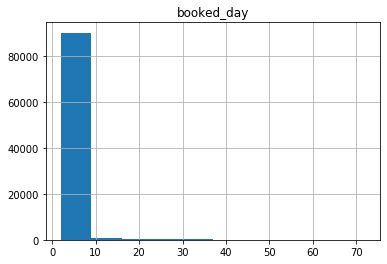

In [22]:
booked_while_tracked.hist('booked_day');

### What percentage of listings got occupied each month?

A higher percentage of May listings got booked (roughly 3% higher)

In [23]:
apr_bookings = booked_while_tracked.loc[booked_while_tracked['occupancy_date'].dt.month == 4]
may_bookings = booked_while_tracked.loc[booked_while_tracked['occupancy_date'].dt.month == 5]
apr_unbooked = unbooked_while_tracked.loc[unbooked_while_tracked['occupancy_date'].dt.month == 4]
may_unbooked = unbooked_while_tracked.loc[unbooked_while_tracked['occupancy_date'].dt.month == 5]

In [24]:
apr_booked_ratio = len(apr_bookings)/(len(apr_unbooked)+len(apr_bookings))
print('Apr Booked:  \t{:0.1f}%'.format((apr_booked_ratio)*100))
may_booked_ratio = len(may_bookings)/(len(may_unbooked)+len(may_bookings))
print('May Booked:  \t{:0.1f}%'.format((may_booked_ratio)*100))

Apr Booked:  	58.5%
May Booked:  	61.4%


### How much revenue was generated each month?

More May listings were booked overall, but more dollars were spent per April listing.  
Interestingly, a higher percentage of potential revenue dollars were covered in May listings than April listings.

In [25]:
print('Apr Revenue (Tot): ${:,.0f}'.format(apr_bookings['final_price'].sum()))
print('May Revenue (Tot): ${:,.0f}'.format(may_bookings['final_price'].sum()))
print('Apr Revenue (Ave/Night): ${:,.0f}'.format(apr_bookings['final_price'].mean()))
print('May Revenue (Ave/Night): ${:,.0f}'.format(may_bookings['final_price'].mean()))
print('Apr Revenue (Mid/Night): ${:,.0f}'.format(apr_bookings['final_price'].median()))
print('May Revenue (Mid/Night): ${:,.0f}'.format(may_bookings['final_price'].median()))

potential_revenue_apr = cleaned_tracked.loc[cleaned_tracked['occupancy_date'].dt.month == 4, 'final_price'].sum()
potential_revenue_may = cleaned_tracked.loc[cleaned_tracked['occupancy_date'].dt.month == 5, 'final_price'].sum()

print('%Potential Revenue (Apr): {:0.1f}%'.format(apr_bookings['final_price'].sum()/potential_revenue_apr*100))
print('%Potential Revenue (May): {:0.1f}%'.format(may_bookings['final_price'].sum()/potential_revenue_may*100))

Apr Revenue (Tot): $10,618,517
May Revenue (Tot): $14,232,047
Apr Revenue (Ave/Night): $293
May Revenue (Ave/Night): $256
Apr Revenue (Mid/Night): $155
May Revenue (Mid/Night): $125
%Potential Revenue (Apr): 59.8%
%Potential Revenue (May): 63.0%


### Ave Occupancy and Revenue Per Scraping ID:

Average revenue across both months shows us a longer term picture, and average revenue per day listed tells us more about economics related to being available to be booked. If we're going to be owning all these properties, we should know both what the total revenue is across all days of the month, but also the total revenue over all days this listing possibly could have been booked.  
Ave Occupancy per unit (all Apr+May) tells us how the overall Phx market is doing


In [26]:
# Functions for aggregations of pandas series that can handle NaNs (where e.g. price drops didnd't happen)
def pct(x: pd.Series):
    return 100*sum(x)/len(x)

def mean(x: pd.Series):
    return np.nanmean(np.array(x))

# Here we do the important task of combining all days a specific unit was offered into s single history per unit.
history_by_listing = \
    cleaned_tracked.groupby(['scraping_id'])\
                    .agg({
                            'final_price': mean,
                            'least_price': mean,
                            'got_booked': pct,
                            'n_price_drops': mean,
                            'ave_price_drop_pct': mean,
                            'max_price_drop_pct': max,
                            'first_price_drop_day': mean,
                            'final_price_drop_day': [mean, min],
                            'revenue':  [sum, mean],
                            })\
                    .reset_index()
history_by_listing.columns = ["_".join(x) for x in history_by_listing.columns.ravel()]

In [27]:
# let's combine the details of the unit and the pricing/availability history of the unit.
listings=history_by_listing.merge(details, left_on='scraping_id_', right_on='scraping_id')\
                           .drop(columns=['scraping_id_'])
listings.head()

,final_price_mean,least_price_mean,got_booked_pct,n_price_drops_mean,ave_price_drop_pct_mean,max_price_drop_pct_max,first_price_drop_day_mean,final_price_drop_day_mean,final_price_drop_day_min,revenue_sum,...,lat,mapped_location,name,capacity,bathrooms,bedrooms,has_pool,cleaning_fee,is_superhost,host_name
0,115.514286,112.000000,48.571429,2.685714,8.191133,23.33,39.741935,23.354839,1.0,1958.0,...,33.496566,https://maps.google.com/maps?q=33.496565678911...,Old Town Scottsdale Vacation Home & GIANTS Rental,7,2.5,2.0,1,150.0,1,Mj
1,72.272727,72.242424,63.636364,2.000000,5.066035,34.86,18.000000,7.857143,1.0,1517.0,...,33.463182,https://maps.google.com/maps?q=33.463182488027...,Upscale Townhouse South Scottsdale,4,1.5,2.0,1,85.0,1,Jamil
2,76.714286,76.714286,100.000000,0.000000,0.000000,0.00,NaN,NaN,NaN,1074.0,...,33.607810,https://maps.google.com/maps?q=33.607809726520...,North Scottsdale/ PV Private Guest House w/pool,4,1.0,0.0,1,75.0,1,Julie And Bill
3,94.878049,94.780488,63.414634,1.317073,14.241220,45.12,12.827586,8.275862,1.0,2709.0,...,33.499397,https://maps.google.com/maps?q=33.499396773678...,Mountain View Paradise*Heated Pool*Spa*Gym,4,1.0,1.0,1,100.0,1,Vanessa
4,70.000000,70.000000,66.666667,0.000000,0.000000,0.00,NaN,NaN,NaN,140.0,...,33.490571,https://maps.google.com/maps?q=33.490570685645...,Modern Luxury Scottsdale Condo!,5,1.0,2.0,1,150.0,1,Sara


In [28]:
print('Ave Revenue per unit (all Apr+May): ${:,.0f}'.format(listings['revenue_sum'].mean()) )
print('Ave Revenue per unit (per day): ${:,.0f}'.format(listings['revenue_mean'].mean()) )
print('Ave Occupancy per unit (all Apr+May): {:0.1f}%'.format(listings['got_booked_pct'].mean()) )

Ave Revenue per unit (all Apr+May): $5,901
Ave Revenue per unit (per day): $141
Ave Occupancy per unit (all Apr+May): 59.5%


### Ave revenue and occupancy by number of bedrooms in unit:



Ave Revenue per 4Bd unit (all Apr+May): $7,331
Ave Revenue per 4Bd unit (per day): $179


Ave Revenue per 3Bd unit (all Apr+May): $10,724
Ave Revenue per 3Bd unit (per day): $236


Ave Revenue per 2Bd unit (all Apr+May): $3,522
Ave Revenue per 2Bd unit (per day): $81


Ave Revenue per 1Bd unit (all Apr+May): $1,745
Ave Revenue per 1Bd unit (per day): $62


Ave Revenue per 0Bd unit (all Apr+May): $1,075
Ave Revenue per 0Bd unit (per day): $53


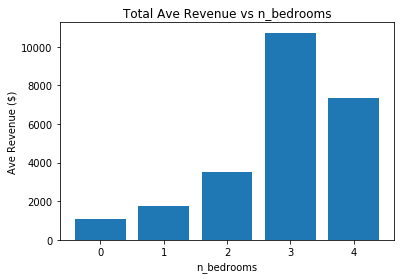

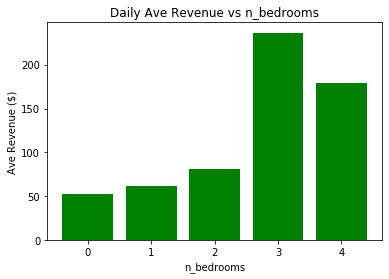

In [29]:
print('\n')
print('Ave Revenue per 4Bd unit (all Apr+May): ${:,.0f}'.format(listings.loc[listings['bedrooms']==4, 'revenue_sum'].mean()) )
print('Ave Revenue per 4Bd unit (per day): ${:,.0f}'.format(listings.loc[listings['bedrooms']==4, 'revenue_mean'].mean()) )
print('\n')
print('Ave Revenue per 3Bd unit (all Apr+May): ${:,.0f}'.format(listings.loc[listings['bedrooms']==3, 'revenue_sum'].mean()) )
print('Ave Revenue per 3Bd unit (per day): ${:,.0f}'.format(listings.loc[listings['bedrooms']==3, 'revenue_mean'].mean()) )
print('\n')
print('Ave Revenue per 2Bd unit (all Apr+May): ${:,.0f}'.format(listings.loc[listings['bedrooms']==2, 'revenue_sum'].mean()) )
print('Ave Revenue per 2Bd unit (per day): ${:,.0f}'.format(listings.loc[listings['bedrooms']==2, 'revenue_mean'].mean()) )
print('\n')
print('Ave Revenue per 1Bd unit (all Apr+May): ${:,.0f}'.format(listings.loc[listings['bedrooms']==1, 'revenue_sum'].mean()) )
print('Ave Revenue per 1Bd unit (per day): ${:,.0f}'.format(listings.loc[listings['bedrooms']==1, 'revenue_mean'].mean()) )
print('\n')
print('Ave Revenue per 0Bd unit (all Apr+May): ${:,.0f}'.format(listings.loc[listings['bedrooms']==0, 'revenue_sum'].mean()) )
print('Ave Revenue per 0Bd unit (per day): ${:,.0f}'.format(listings.loc[listings['bedrooms']==0, 'revenue_mean'].mean()) )

bedrooms = [0,1,2,3,4]
ave_rev_all = [0]*len(bedrooms)
ave_rev_daily = [0]*len(bedrooms)
for i, b in enumerate(bedrooms):
    ave_rev_all[i] = listings.loc[listings['bedrooms']==b, 'revenue_sum'].mean()
    ave_rev_daily[i] = listings.loc[listings['bedrooms']==b, 'revenue_mean'].mean()

plt.bar(bedrooms, ave_rev_all)
plt.xlabel('n_bedrooms')
plt.ylabel('Ave Revenue ($)')
plt.title('Total Ave Revenue vs n_bedrooms')
plt.show()

plt.bar(bedrooms, ave_rev_daily, color='g')
plt.xlabel('n_bedrooms')
plt.ylabel('Ave Revenue ($)')
plt.title('Daily Ave Revenue vs n_bedrooms')

plt.show()

### Distribution of booking percantage across listings:

a lot of units did extremely well in occupancy rates, and others faired poorly. The rest 
is fairly evenly spread but centered slightly around 60%

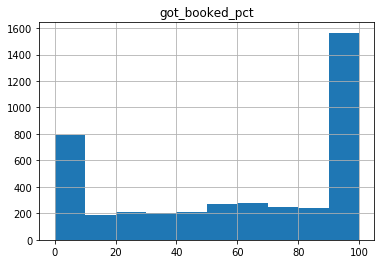

In [30]:
listings.hist('got_booked_pct');

### What percentage of listings were filled without the need for a price drop?

If you do drop price, you have a 1.6% higher chance of getting booked. (61.1% vs 59.5%)

In [31]:
#breakdown by booked vs unbooked first, then by pricedrop status
unbooked_ratio = 100*len_unbooked_while_tracked/len_cleaned_tracked
booked_ratio = 100*len_booked_while_tracked/len_cleaned_tracked
#n_examples
len_booked_with_pd = len(booked_while_tracked.loc[booked_while_tracked['n_price_drops'] > 0])
len_booked_no_pd   = len(booked_while_tracked.loc[booked_while_tracked['n_price_drops'] == 0])
len_unbooked_with_pd = len(unbooked_while_tracked.loc[unbooked_while_tracked['n_price_drops'] > 0])
len_unbooked_no_pd   = len(unbooked_while_tracked.loc[unbooked_while_tracked['n_price_drops'] == 0])
#ratios
booked_with_pd_ratio = 100*len_booked_with_pd/len_booked_while_tracked
booked_no_pd_ratio = 100*len_booked_no_pd/len_booked_while_tracked
unbooked_with_pd_ratio = 100*len_unbooked_with_pd/len_unbooked_while_tracked
unbooked_no_pd_ratio = 100*len_unbooked_no_pd/len_unbooked_while_tracked


#breakdown by pricedrop vs no pricedrop first, then by booking status
price_dropped_df = cleaned_tracked.loc[cleaned_tracked['n_price_drops'] > 0]
no_price_dropped_df = cleaned_tracked.loc[cleaned_tracked['n_price_drops'] == 0]
len_pd = len(price_dropped_df)
len_no_pd = len(no_price_dropped_df)
pd_ratio = 100*len_pd/(len_cleaned_tracked)
no_pd_ratio = 100*len_no_pd/(len_cleaned_tracked)
#n_examples
len_pd_booked = len(price_dropped_df.loc[price_dropped_df['got_booked'] == True])
len_pd_unbooked = len(price_dropped_df.loc[price_dropped_df['got_booked'] == False])
len_no_pd_booked = len(no_price_dropped_df.loc[no_price_dropped_df['got_booked'] == True])
len_no_pd_unbooked = len(no_price_dropped_df.loc[no_price_dropped_df['got_booked'] == False])
#ratios
pd_booked_ratio = 100*len_pd_booked/len_pd
pd_unbooked_ratio = 100*len_pd_unbooked/len_pd
no_pd_booked_ratio = 100*len_no_pd_booked/len_no_pd
no_pd_unbooked_ratio = 100*len_no_pd_unbooked/len_no_pd

print('All listings in consideration: \t{:,}'.format(len_cleaned_tracked))
print('\n')
print('\tListings went unbooked: \t {:,} ({:0.1f}%)'.format(len_unbooked_while_tracked, unbooked_ratio))
print('\tListings went booked: \t\t {:,} ({:0.1f}%)'.format(len_booked_while_tracked, booked_ratio))
print('\t\tOf booked, with pricedrop: \t\t {:,} ({:0.1f}%)'.format(len_booked_with_pd, booked_with_pd_ratio))
print('\t\tOf booked, without pricedrop: \t\t {:,} ({:0.1f}%)'.format(len_booked_no_pd, booked_no_pd_ratio))
print('\t\tOf unbooked, with pricedrop: \t\t {:,} ({:0.1f}%)'.format(len_unbooked_with_pd, unbooked_with_pd_ratio))
print('\t\tOf unbooked, without pricedrop: \t {:,} ({:0.1f}%)'.format(len_unbooked_no_pd, unbooked_no_pd_ratio))
print('\n')
print('\tListings with pricedrop: \t {:,} ({:0.1f}%)'.format(len_pd,  pd_ratio))
print('\tListings without pricedrop: \t {:,} ({:0.1f}%)'.format(len_no_pd, no_pd_ratio))
print('\t\tOf pricedrop, booked: \t\t\t {:,} ({:0.1f}%)'.format(len_pd_booked, pd_booked_ratio))
print('\t\tOf pricedrop, unbooked: \t\t {:,} ({:0.1f}%)'.format(len_pd_unbooked, pd_unbooked_ratio))
print('\t\tOf no pricedrop, booked: \t\t {:,} ({:0.1f}%)'.format(len_no_pd_booked, no_pd_booked_ratio))
print('\t\tOf no pricedrop, unbooked:\t\t {:,} ({:0.1f}%)'.format(len_no_pd_unbooked, no_pd_unbooked_ratio))

# print('Price had dropped among booked:  \t{:0.1f}%'.format(booked_post_pricedrop_ratio*100))

All listings in consideration: 	152,647


	Listings went unbooked: 	 60,760 (39.8%)
	Listings went booked: 		 91,887 (60.2%)
		Of booked, with pricedrop: 		 38,240 (41.6%)
		Of booked, without pricedrop: 		 53,647 (58.4%)
		Of unbooked, with pricedrop: 		 24,301 (40.0%)
		Of unbooked, without pricedrop: 	 36,459 (60.0%)


	Listings with pricedrop: 	 62,541 (41.0%)
	Listings without pricedrop: 	 90,106 (59.0%)
		Of pricedrop, booked: 			 38,240 (61.1%)
		Of pricedrop, unbooked: 		 24,301 (38.9%)
		Of no pricedrop, booked: 		 53,647 (59.5%)
		Of no pricedrop, unbooked:		 36,459 (40.5%)


### Predicting Booking Rate based on unit characteristics:

Standard machine learning here (classic max likelihood regressor) doesn't do a good job at predicting the occupancy percentage of a listing. Even after we use elastic net (a combo of ridge regression + lasso). This is likely due to the small-data nature of the problem (we're now on the order of 1000s of examples). Later, 
I opted to try a Bayesian approach (classic bayesian regressor) using Markov Chain Monte Carlo methods (MCMC). I wish I had more time to play around with this approach as it seems promising (e.g. to regress to revenue rather than occupancy rate, etc)

#### OLS

In [32]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV

cols_list = ['final_price_mean', 'least_price_mean', 
             'n_price_drops_mean', 'ave_price_drop_pct_mean', 
             'max_price_drop_pct_max', 'city', 'capacity', 
             'bathrooms', 'bedrooms', 'has_pool',
             'cleaning_fee', 'is_superhost', 'got_booked_pct']
regression_dataset = listings[cols_list].dropna()
y = regression_dataset[cols_list.pop(-1)]
X = regression_dataset[cols_list]

# transform city to a categorical
encoder = LabelEncoder().fit(X['city'].astype(np.str))
print(encoder.classes_)
X['city'] = encoder.transform(X['city'])

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

EN = ElasticNetCV().fit(X_train, y_train)
r2_EN = EN.score(X_test, y_test)
r2_EN

['Phoenix' 'Scottsdale' 'Tempe']


0.041912673958231395

In [33]:
percent_missing = X.isnull().sum() * 100 / len(X)
missing_value_df = pd.DataFrame({
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
missing_value_df

,percent_missing
final_price_mean,0.0
least_price_mean,0.0
n_price_drops_mean,0.0
ave_price_drop_pct_mean,0.0
max_price_drop_pct_max,0.0
city,0.0
capacity,0.0
bathrooms,0.0
bedrooms,0.0
has_pool,0.0


In [34]:
dict(zip(X.columns, EN.coef_))

{'final_price_mean': -0.0026791949412067867,
 'least_price_mean': 0.0052314301147063196,
 'n_price_drops_mean': 0.864080085517395,
 'ave_price_drop_pct_mean': 0.004556156934571992,
 'max_price_drop_pct_max': -0.033326660886732126,
 'city': 0.0,
 'capacity': -0.9234029800759526,
 'bathrooms': 0.5245165468178493,
 'bedrooms': 0.5755471836523895,
 'has_pool': 0.0,
 'cleaning_fee': -0.04663214127941328,
 'is_superhost': 0.0}

In [35]:
cols_list2 = ['n_price_drops_mean', 
              'max_price_drop_pct_max',
              'capacity',
              'bathrooms',
              'bedrooms',
              'cleaning_fee'
             ]
X = regression_dataset[cols_list2]

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

EN = ElasticNetCV().fit(X_train, y_train)
r2_EN = EN.score(X_test, y_test)
r2_EN

0.03905269861408878

#### Bayesian Regression

Let's try a Bayesian method since we have a small dataset. We're approximating with the following equation:

got_booked_pct ~ final_price_mean + least_price_mean + n_price_drops_mean + ave_price_drop_pct_mean + max_price_drop_pct_max + city + capacity + bathrooms + bedrooms + has_pool + cleaning_fee + is_superhost


The plots below seem to preliminarily indicate the following  reliably influence the occupancy rate of a unit: 

- being in Tempe reliably increases occupancy rates
- the more price drops you're willing to make, there's weakly better odds of higher occupancy rates
- the more you have to drop your price by every time, the less the chance of occupancy
- higher cleaning fees do have a legitimate case for deterring occupancy

But let me be clear here: There's a lot of overlapping features here with significant correlations (see the plots below) that make the results dubious. A bit more feature engineering to get less overlap would prevent us from overrelying on the minute differences between highly correlated features and hence lessen spurious correlations. 

An interesting next direction may be to try making a heirarchical bayesian model, especially considering the 
high correlations of some of the factors like capacity and bedrooms. With a heirarchical model, the identified correlations between no longer become an issue. 

In [83]:
import pymc3 as pm
import seaborn

cols_list = ['final_price_mean', 'least_price_mean', 
             'n_price_drops_mean', 'ave_price_drop_pct_mean', 
             'max_price_drop_pct_max', 'city', 'capacity', 
             'bathrooms', 'bedrooms', 'has_pool',
             'cleaning_fee', 'is_superhost', 'got_booked_pct']
dataset = listings[cols_list].dropna()
cols_to_norm = ['final_price_mean', 'least_price_mean', 'cleaning_fee', 'max_price_drop_pct_max', 'ave_price_drop_pct_mean', 'got_booked_pct']
means = dataset.mean()
for col in cols_to_norm:
    dataset[col] = dataset[col] / means[col]
    


In [63]:
dataset.head()

,final_price_mean,least_price_mean,n_price_drops_mean,ave_price_drop_pct_mean,max_price_drop_pct_max,city,capacity,bathrooms,bedrooms,has_pool,cleaning_fee,is_superhost,got_booked_pct
0,0.495354,0.490969,2.685714,1.369344,1.389668,Scottsdale,7,2.5,2.0,1,1.043149,1,0.810325
1,0.309924,0.316686,2.000000,0.846909,2.076460,Scottsdale,4,1.5,2.0,1,0.591118,1,1.061656
2,0.328970,0.336289,0.000000,0.000000,0.000000,Scottsdale,4,1.0,0.0,1,0.521574,1,1.668316
3,0.406861,0.415485,1.317073,2.380761,2.687604,Scottsdale,4,1.0,1.0,1,0.695433,1,1.057957
4,0.300178,0.306856,0.000000,0.000000,0.000000,Scottsdale,5,1.0,2.0,1,1.043149,1,1.112211


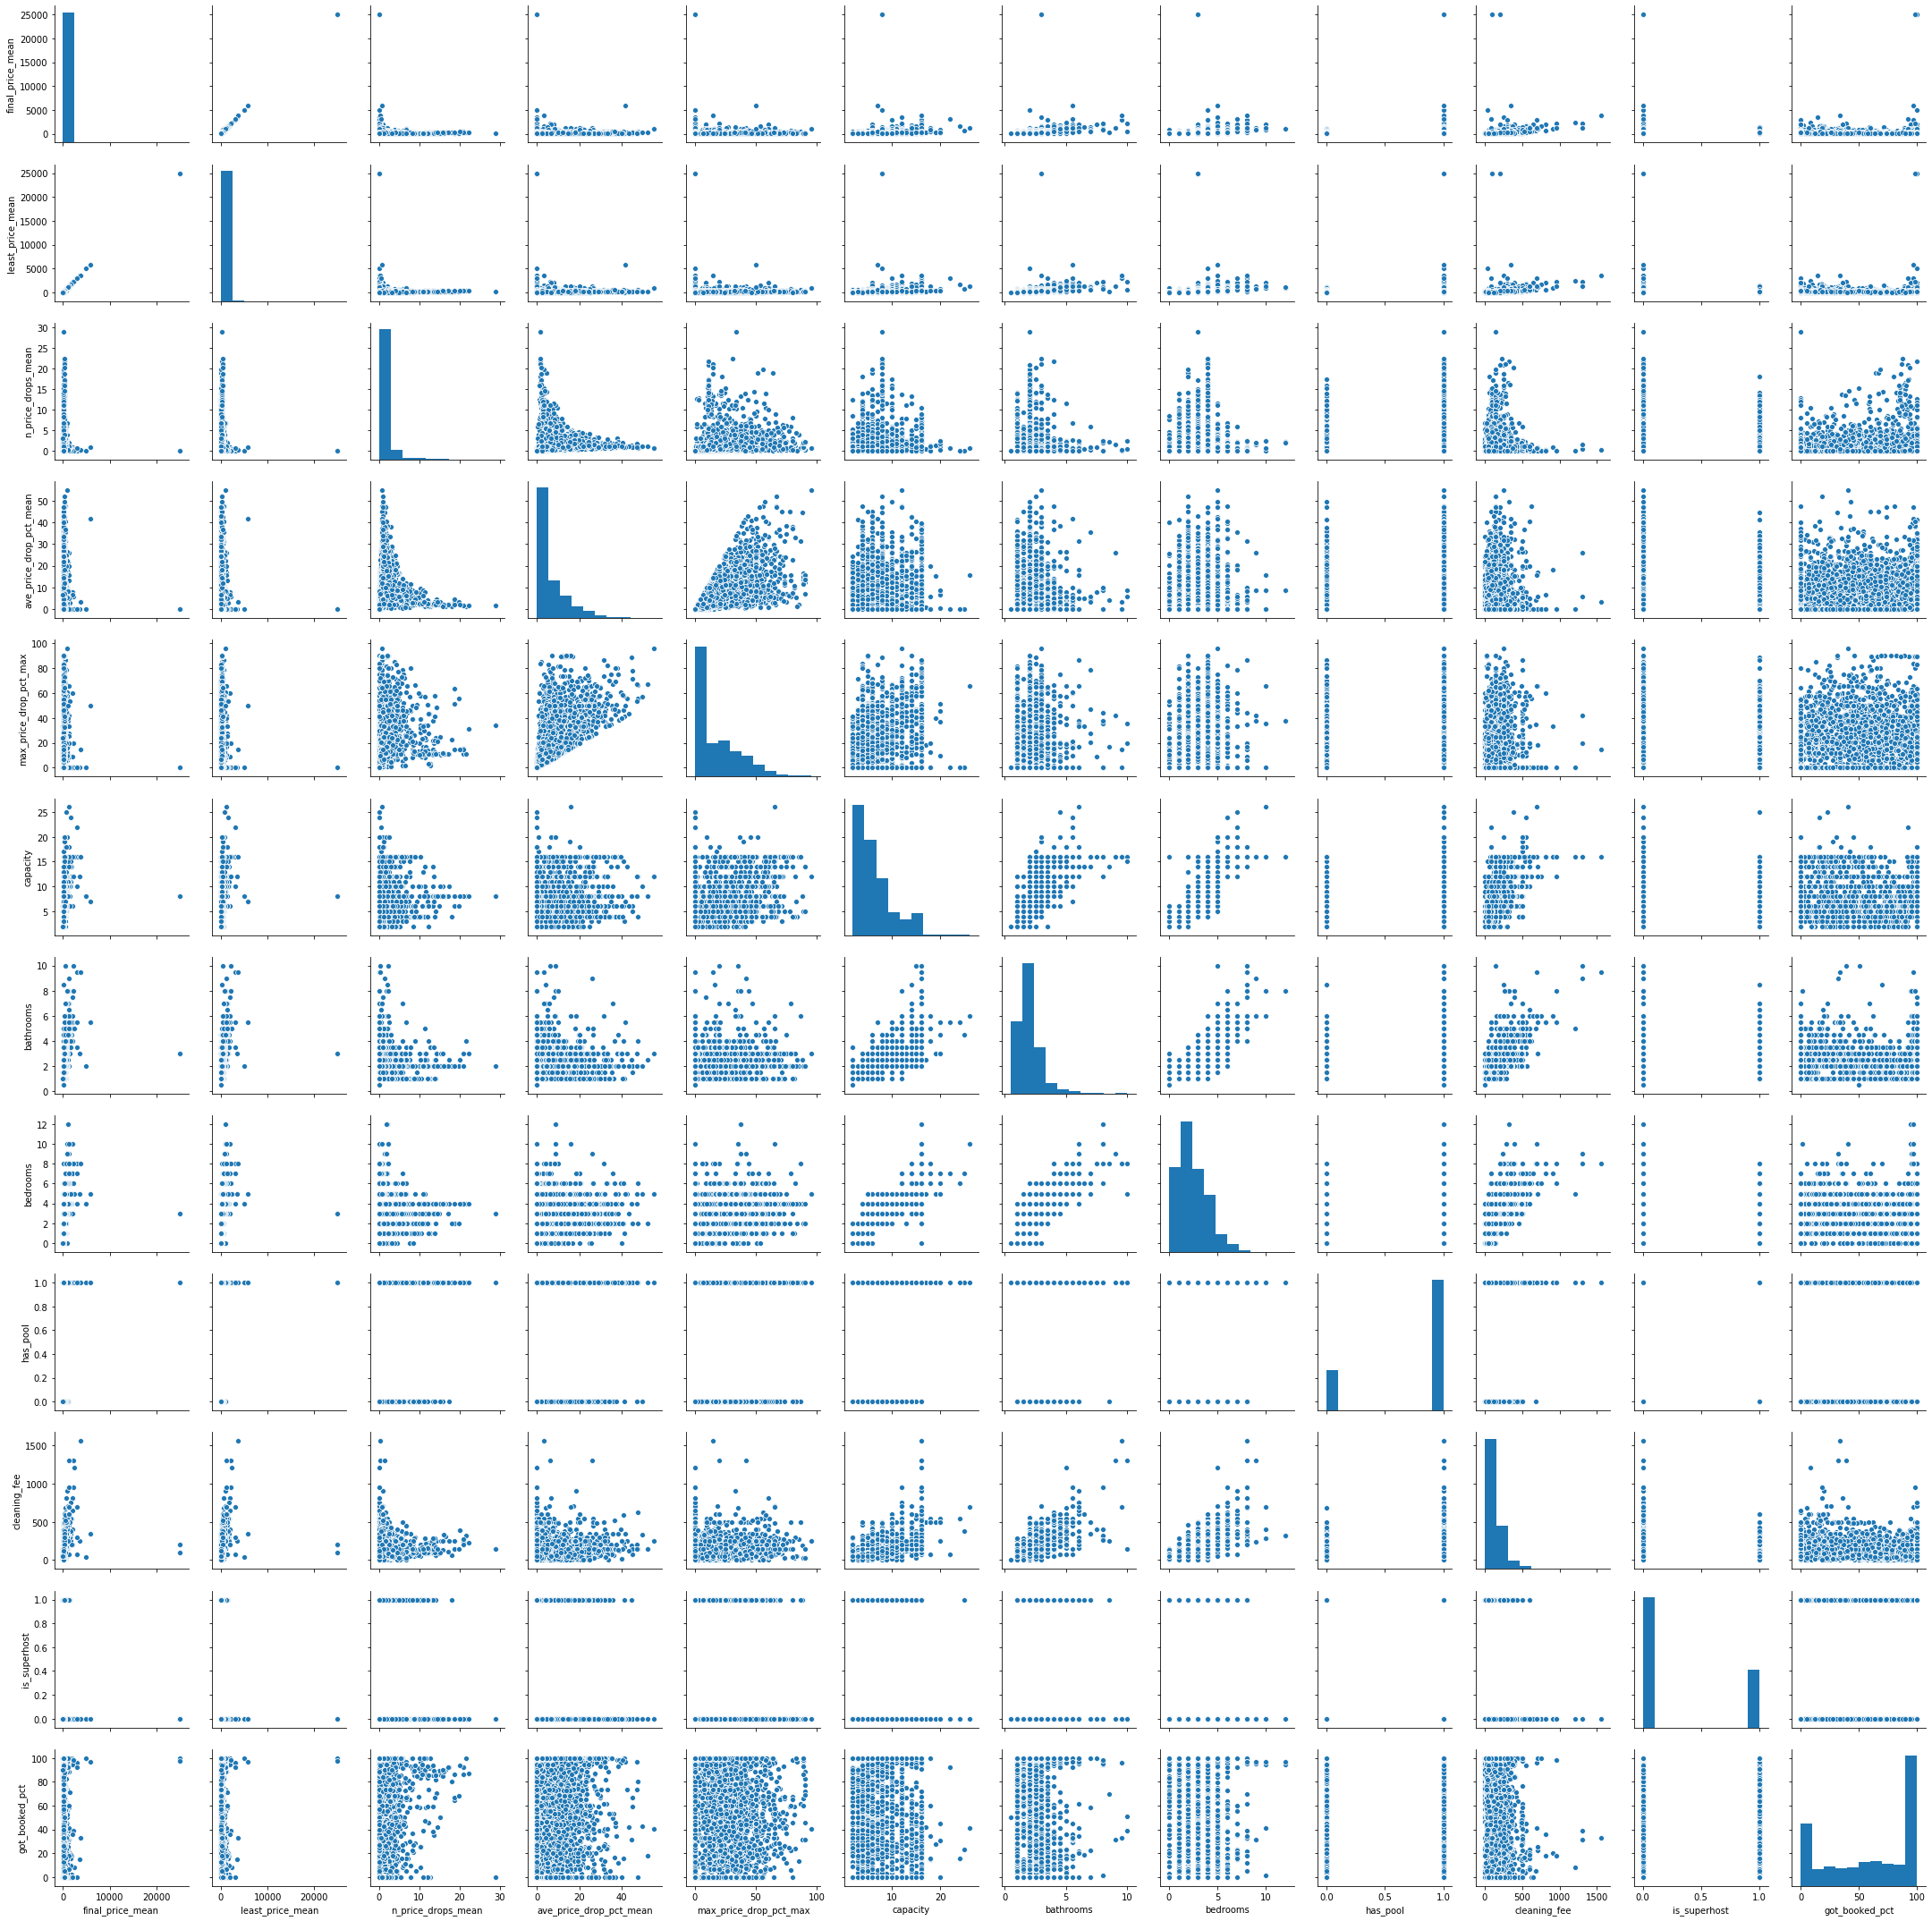

In [498]:
seaborn.pairplot(dataset)

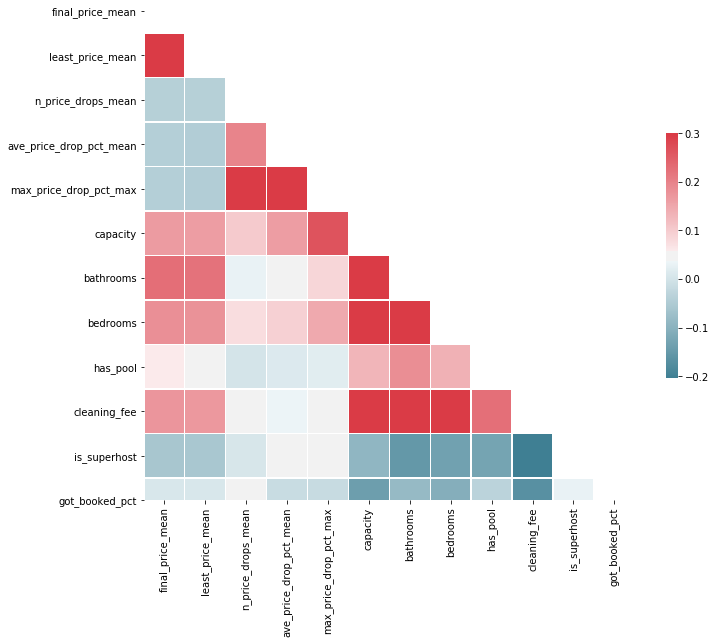

In [499]:
# Compute the correlation matrix
corr = dataset.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = seaborn.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
seaborn.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);


interesting... superhosts have lower cleaning fees?!

In [84]:
formula = 'got_booked_pct ~ {}'.format(' + '.join(cols_list[:-1]))
# formula = '''
# got_booked_pct ~ bathrooms + bedrooms + cleaning_fee + is_superhost + has_pool + n_price_drops_mean
# '''
print(formula)

# Context for the model
with pm.Model() as normal_model:
    
    # The prior for the data likelihood is usually a Normal Distribution
    # Student-T distributions have more weight at the tails. This makes them ideal for more robust estimations.
#     family = pm.glm.families.Normal()
    family = pm.glm.families.StudentT()
    
    # Creating the model requires a formula and data (and optionally a family)
    pm.GLM.from_formula(formula, data=dataset, family=family)
    
    # Perform Markov Chain Monte Carlo sampling letting PyMC3 choose the algorithm
    normal_trace = pm.sample(draws=3000, tune=1000, chains=3, cores=1)


got_booked_pct ~ final_price_mean + least_price_mean + n_price_drops_mean + ave_price_drop_pct_mean + max_price_drop_pct_max + city + capacity + bathrooms + bedrooms + has_pool + cleaning_fee + is_superhost


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (3 chains in 1 job)
NUTS: [lam, is_superhost, cleaning_fee, has_pool, bedrooms, bathrooms, capacity, max_price_drop_pct_max, ave_price_drop_pct_mean, n_price_drops_mean, least_price_mean, final_price_mean, city[T.Tempe], city[T.Scottsdale], Intercept]
100%|██████████| 4000/4000 [10:19<00:00,  6.46it/s]


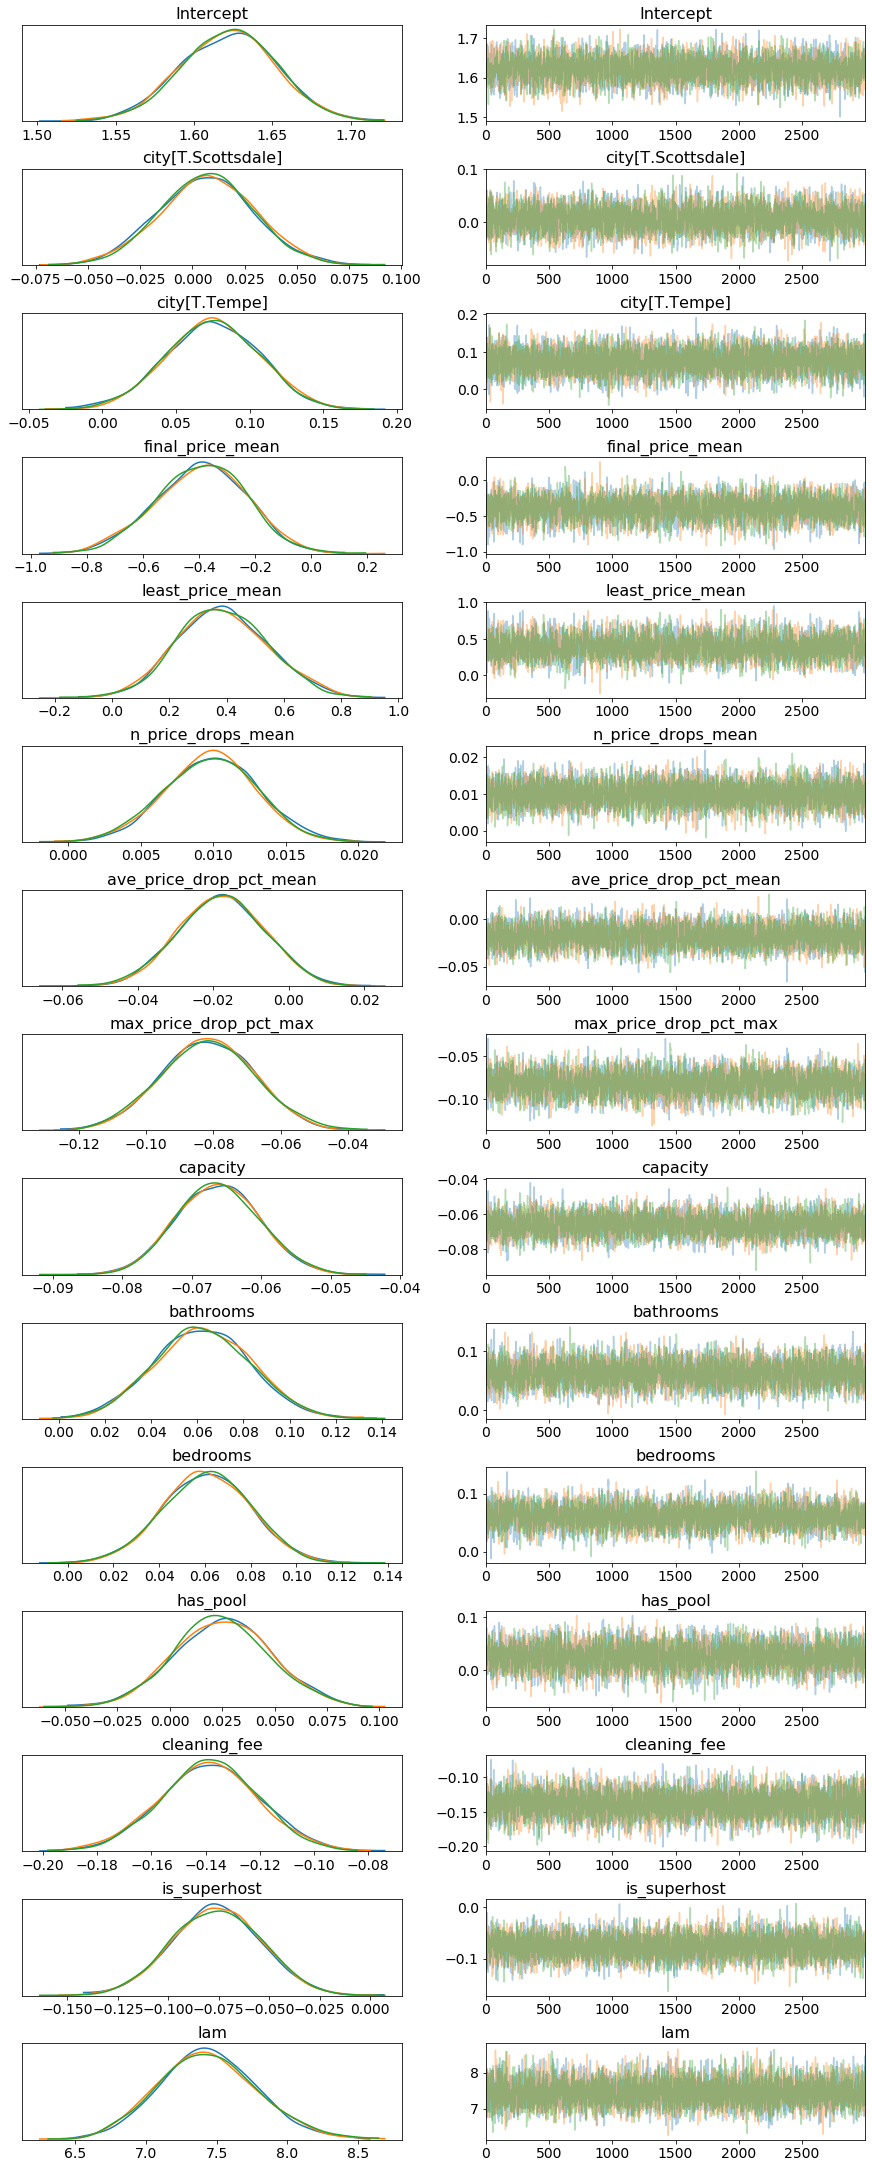

In [85]:
pm.traceplot(normal_trace);

In [69]:
dataset.mean()

final_price_mean                 (0.9999999999999988+0j)
least_price_mean                 (0.9999999999999988+0j)
n_price_drops_mean               (1.1961388997282048+0j)
ave_price_drop_pct_mean          (0.9999999999999997+0j)
max_price_drop_pct_max           (0.9999999999999981+0j)
city                       (5.787376e-318+6.72972e-318j)
capacity                          (6.455437871351072+0j)
bathrooms                        (2.0120123998966677+0j)
bedrooms                          (2.535778868509429+0j)
has_pool                         (0.7638853009558254+0j)
cleaning_fee                     (0.9999999999999916+0j)
is_superhost                     (0.3081890984241798+0j)
got_booked_pct                   (0.9999999999999938+0j)
dtype: complex128